# Visualising Wind Farm Locations

<br>

### Imports

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Spatial Manipulation
import geopandas as gpd
from shapely import geometry

# Misc
import os
import operator
import requests
import functools
from ipypb import track
from datetime import date

<br>

### Helper Functions

In [2]:
def hide_spines(ax, positions=['top', 'right']):
    """
    Pass a matplotlib axis and list of positions with spines to be removed
    
    args:
        ax:          Matplotlib axis object
        positions:   Python list e.g. ['top', 'bottom']
    """
    assert isinstance(positions, list), 'Position must be passed as a list '
    
    for position in positions:
        ax.spines[position].set_visible(False)
        
def try_accept(exception, default=None):
    def decorator(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            try:
                return func(*args, **kwargs)
            except:
                return exception
        return wrapper
    return decorator

<br>

### Reading In & Forming UK Boundary

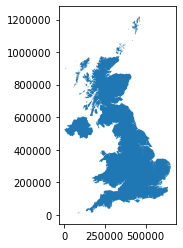

In [3]:
gdf_UK_grouped = gpd.read_file('data/UK-Polygon/UK_polygon.shp')
gdf_UK_grouped.crs = {'init' : 'epsg:27700'}

gdf_UK_grouped['geometry'] = gdf_UK_grouped['geometry'].simplify(2500)
    
gdf_UK_grouped.plot()

<br>

Extracting mainland polygon from UK multipolygon

(108035.40731587316,
 681723.0970525136,
 -36715.021472231565,
 1025125.9306936696)

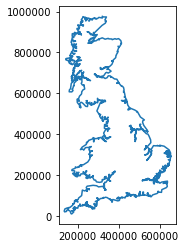

In [4]:
GB_geom = gdf_UK_grouped.loc[0, 'geometry']
EI_geom = gdf_UK_grouped.loc[1, 'geometry']

GB_geom_areas = [GB_geom_poly.area for GB_geom_poly in GB_geom]

index, value = max(enumerate(GB_geom_areas), key=operator.itemgetter(1))
UK_mainland_poly = GB_geom[index]

xys = UK_mainland_poly.exterior.xy 

plt.plot(xys[0], xys[1])
plt.axis('scaled')

<br>

### Reading In & Filtering REPDB

In [5]:
df_REPDB = pd.read_csv('data/REPDB.csv')
df_REPDB.loc[0]

Old Ref ID                                                                           N00053B
Ref ID                                                                                     1
Record Last Updated (dd/mm/yyyy)                                                  07/07/2009
Operator (or Applicant)                                                           RWE npower
Site Name                                                     Aberthaw Power Station Biomass
Technology Type                                                          Biomass (co-firing)
Storage Type                                                                             NaN
Storage Co-location REPD Ref ID                                                          NaN
Installed Capacity (MWelec)                                                               35
CHP Enabled                                                                               No
RO Banding (ROC/MWh)                                                  

In [6]:
s_operational = pd.to_datetime(df_REPDB['Operational'])
s_xcoord = df_REPDB['X-coordinate'].str.replace(',', '').astype(float)
s_ycoord = df_REPDB['Y-coordinate'].str.replace(',', '').astype(float)
s_capacity = df_REPDB['Installed Capacity (MWelec)'].str.replace(',', '').astype(float)
s_technology = df_REPDB['Technology Type']

s_onsh_wind_bool = s_technology=='Wind Onshore'
s_offsh_wind_bool = s_technology=='Wind Offshore'

<br>

### Visualising On- & Off-shore Wind

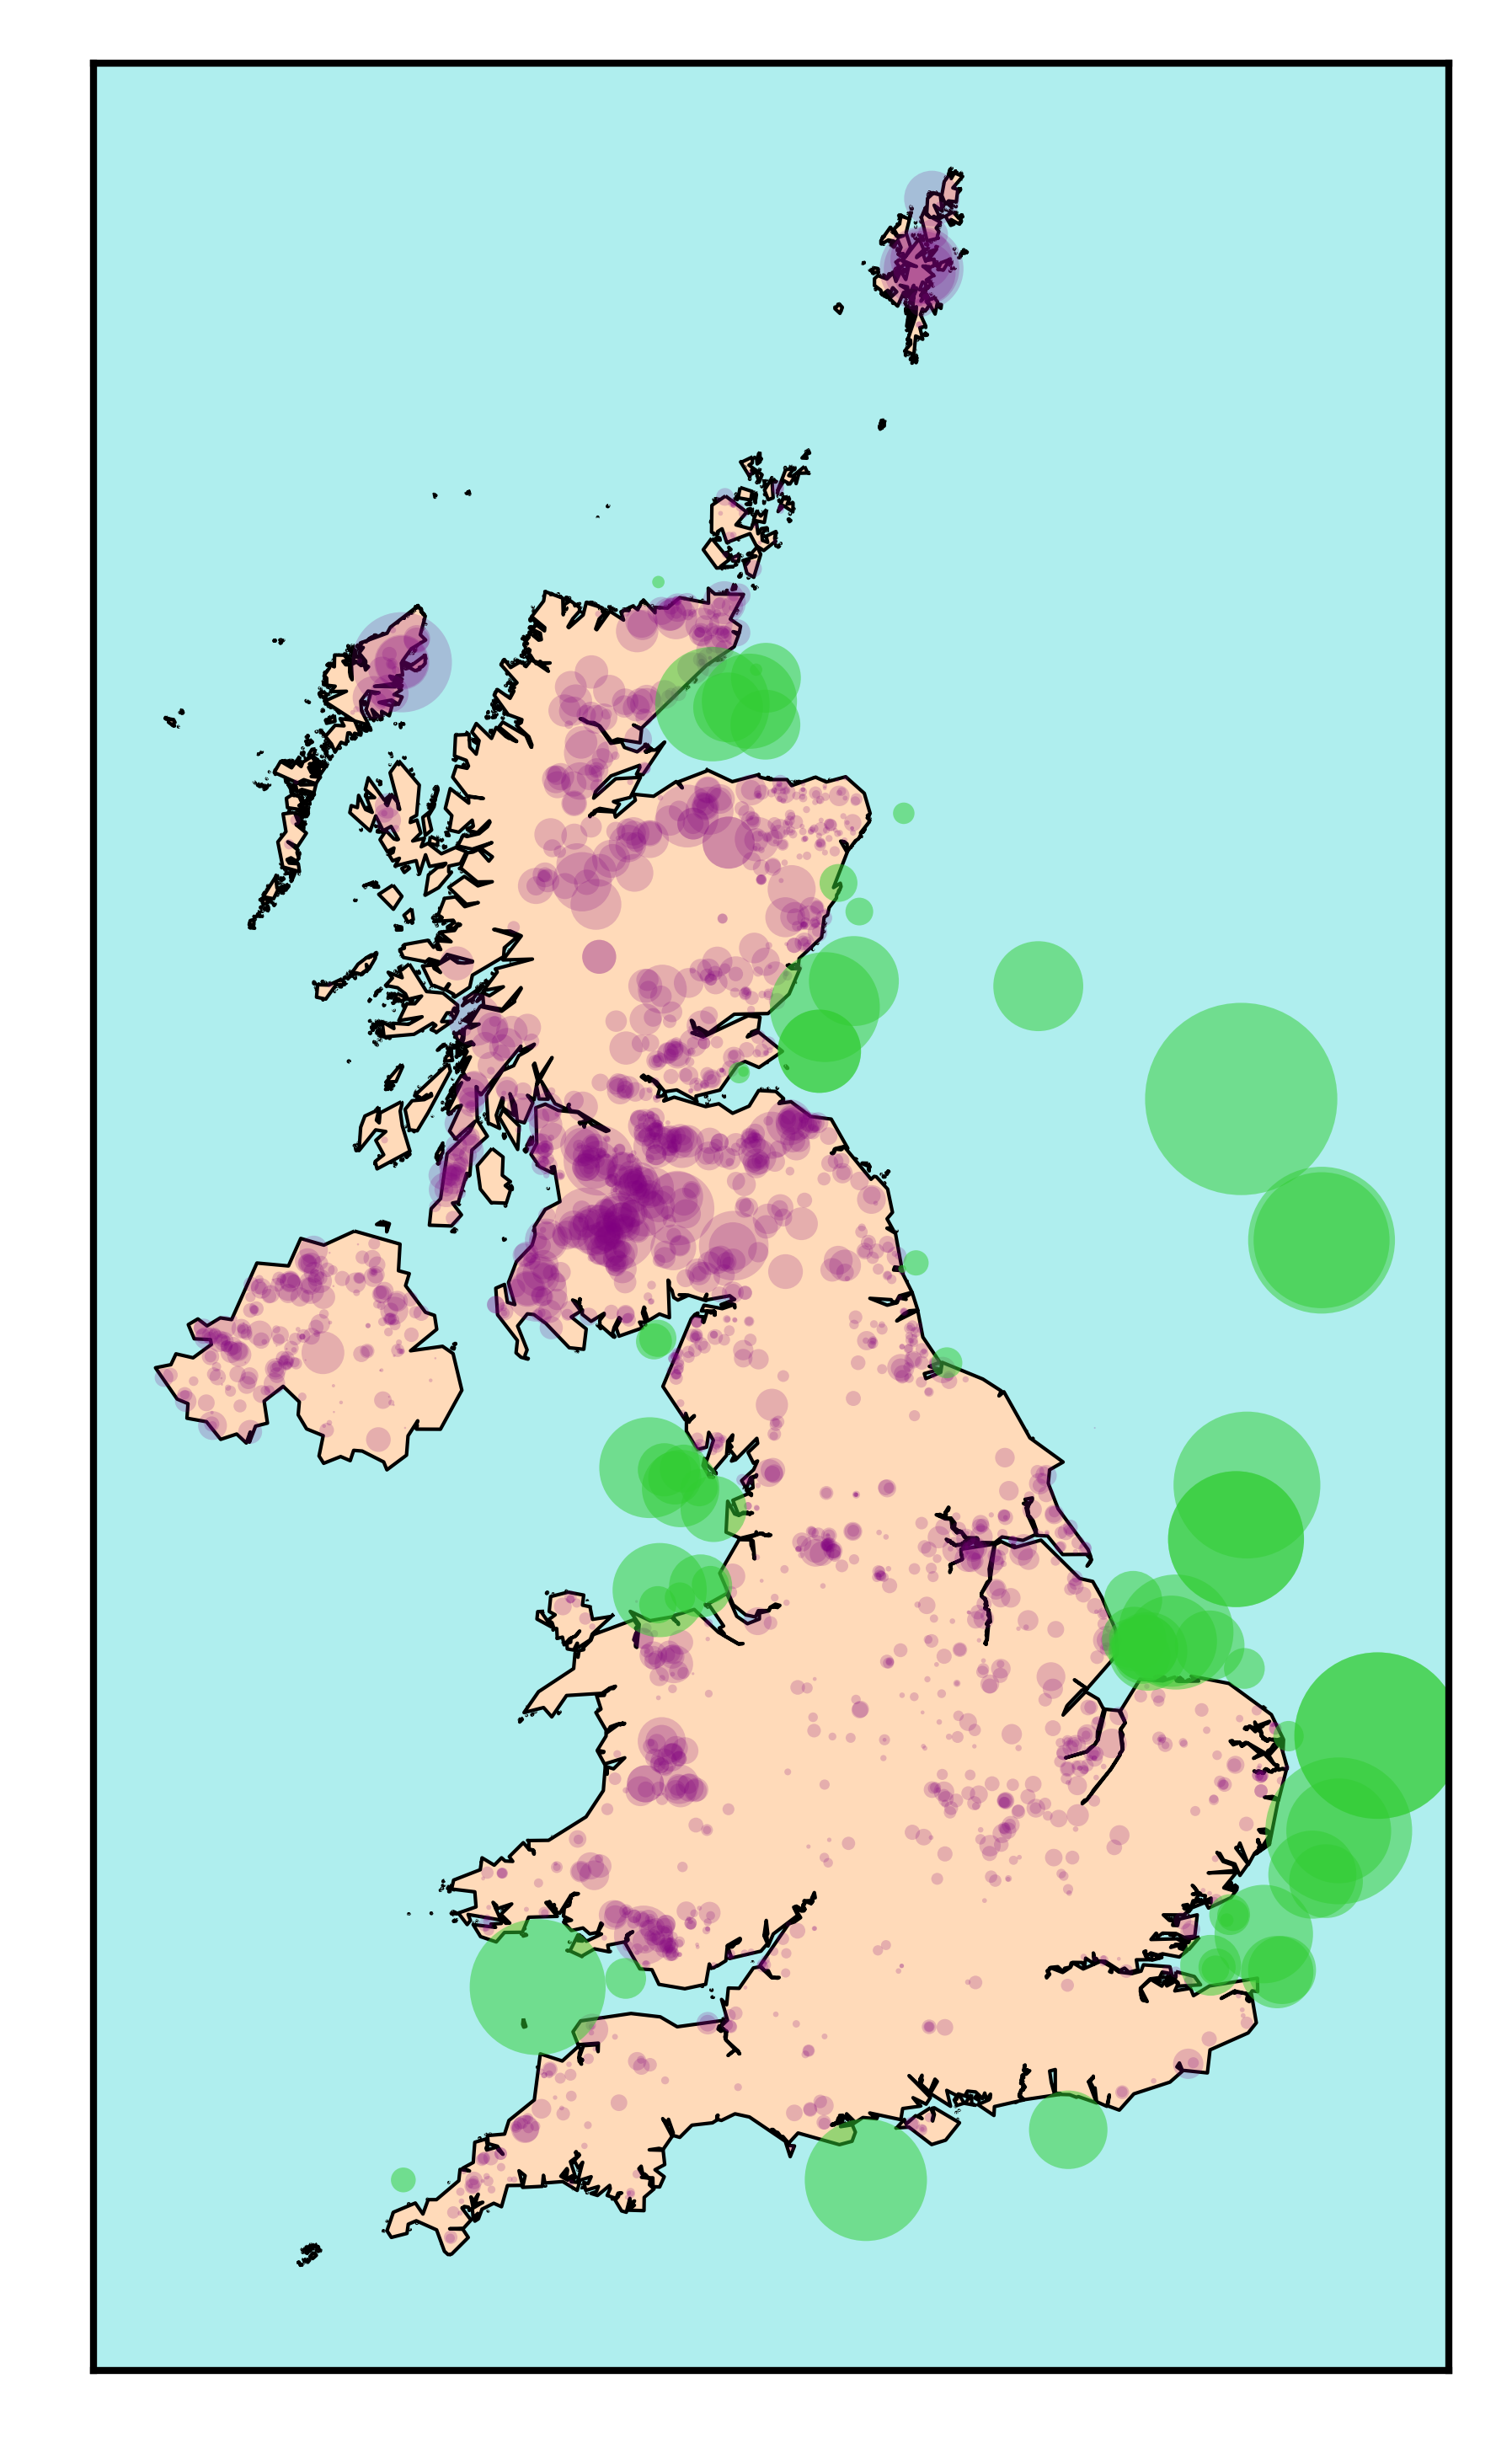

In [9]:
background = 'paleturquoise'

## Plotting
fig, ax = plt.subplots(dpi=750)

gdf_UK_grouped.plot(color='peachpuff', ax=ax, edgecolor='k', lw=0.4)

ax.scatter(s_xcoord[s_onsh_wind_bool], s_ycoord[s_onsh_wind_bool], s=s_capacity[s_onsh_wind_bool]/5, color='purple', alpha=0.2, linewidth=0)
ax.scatter(s_xcoord[s_offsh_wind_bool], s_ycoord[s_offsh_wind_bool], s=s_capacity[s_offsh_wind_bool]/5, color='limegreen', alpha=0.5, linewidth=0)

ax.set_xticks([], [])
ax.set_yticks([], [])

ax.set_facecolor(background)
fig.tight_layout()

fig.savefig('img/UK_wind_locations.png')